# Label Only Membership Inference (Revisited on points)

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{train}$
- Predict API returns **only labels instead of confidence vectors**
- We have some insight on the training data distribution, $D_{out}$ , **but** $D_{train} \cap D_{out} = \varnothing$


### Attack Target: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- Perfom the boundary-based attack on the actual model

### Evaluation Target
- Score over $50\%$ accuracy
- Train attack model based on this assumption and compare with conf-vector attack

Implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia_v1.attack_model import *
from mia_v1.label_only import *
from mia_v1.shadow_models import *
from mia_v1.utilities import *


from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model


In [ ]:
D_TARGET_SIZE = 5000

In [ ]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# use the rest as testing - 'out' records
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=25) 

Epoch 1/25
125/125 [==============================] - 3s 13ms/step - loss: 2.4335 - accuracy: 0.1800 - val_loss: 1.9295 - val_accuracy: 0.2840
Epoch 2/25
125/125 [==============================] - 1s 11ms/step - loss: 1.8829 - accuracy: 0.3142 - val_loss: 2.3912 - val_accuracy: 0.1900
Epoch 3/25
125/125 [==============================] - 1s 11ms/step - loss: 1.8078 - accuracy: 0.3228 - val_loss: 1.7220 - val_accuracy: 0.3620
Epoch 4/25
125/125 [==============================] - 1s 11ms/step - loss: 1.6355 - accuracy: 0.3935 - val_loss: 1.7445 - val_accuracy: 0.3780
Epoch 5/25
125/125 [==============================] - 1s 12ms/step - loss: 1.5424 - accuracy: 0.4345 - val_loss: 1.6306 - val_accuracy: 0.3880
Epoch 6/25
125/125 [==============================] - 1s 12ms/step - loss: 1.4416 - accuracy: 0.4660 - val_loss: 1.6614 - val_accuracy: 0.3740
Epoch 7/25
125/125 [==============================] - 2s 12ms/step - loss: 1.3042 - accuracy: 0.5160 - val_loss: 1.7449 - val_accuracy: 0.3650

### Perturbed Instance Behaviour

Following we will apply some perturbations to data instances from in and out of $D_{target}$ and we will count how the predicted label change in respect to this perturbations, according to each class.



## Shadow Models
Following we define our own shadow models

### Shadow Model Architecture
- 3 CNN layers of $32, 64, 128$ filters of size $3 \times 3$ with MaxPooling and ReLU activation
- Dense Layer of 512 nodes
- Dense Layer of 10 nodes as Output layer

All output logits pass through Softmax Unit as in the target model to acquire probability vectors



### Shadow Dataset Composition

We just divide the CIFAR-10 dataset to $D_{out}$ and $D_{train}$ such as $D_{train} \cap D_{out} = \varnothing$ and use $D_{out}$ in order to train/test shadow models and attack model.

In [ ]:
N_SHADOWS = 5
D_SHADOW_SIZE = 2500

In [ ]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [ ]:
# returns list of (trained shadow_model, D_shadow)
def create_shadows(D_shadows):
  shadow_models_bundle = ShadowModelBatch(len(D_shadows), f_shadow) # shadow model list
  shadow_models_bundle.fit_all(D_shadows, epochs=25)
  return shadow_models_bundle # return a list where every item is (model, acc), train-data, test-data

In [ ]:
# generate shadow datasets
D_shadows = generate_shadow_dataset(target_model, N_SHADOWS, D_SHADOW_SIZE, 10, attacker_images, attacker_labels)

In [ ]:
# train the shadow models
shadow_models = create_shadows(D_shadows)

Epoch 1/25
53/53 [==============================] - 2s 16ms/step - loss: 2.1427 - accuracy: 0.2501 - val_loss: 1.8442 - val_accuracy: 0.3345
Epoch 2/25
53/53 [==============================] - 1s 11ms/step - loss: 1.6387 - accuracy: 0.4018 - val_loss: 1.8400 - val_accuracy: 0.3333
Epoch 3/25
53/53 [==============================] - 1s 10ms/step - loss: 1.4746 - accuracy: 0.4693 - val_loss: 1.8617 - val_accuracy: 0.3636
Epoch 4/25
53/53 [==============================] - 1s 11ms/step - loss: 1.2911 - accuracy: 0.5361 - val_loss: 1.7726 - val_accuracy: 0.4048
Epoch 5/25
53/53 [==============================] - 1s 10ms/step - loss: 1.0336 - accuracy: 0.6388 - val_loss: 1.8089 - val_accuracy: 0.3842
Epoch 6/25
53/53 [==============================] - 1s 10ms/step - loss: 0.8334 - accuracy: 0.7164 - val_loss: 1.9800 - val_accuracy: 0.3733
Epoch 7/25
53/53 [==============================] - 1s 11ms/step - loss: 0.6415 - accuracy: 0.7869 - val_loss: 1.9277 - val_accuracy: 0.4109
Epoch 8/25
53

## Attack Model

### Attack Model Architecture
The attack model is consisted of 1 swallow layer of 10 neurons just as proposed in Shokri et al. and in the relative label only attack paper.


### Attack Dataset
The attack dataset will be consisted of vectors $x_i$, s.t. $x_i$ contains:
- real label
- predicted label
- bitstring of length $n'$, where $x_{ij+2}, \; j \in \{1, ..., n'\} $ will be 1 if perturbed label is same as predicted, otherwise it'll be zero.


### Perturbed Queries for feature extraction and Attack Dataset

In order to construct the actual attack dataset we have 2 perturbation functions:
- Translate
- Rotate

that can apply the necessary augmentations in order to acquire the feature vector for a query.

This works by applying all augmentations to the input X and querying the target model in order to return a binary vector $x_{attack}$ where $$x_{attack_p} = 1 \; if \;y_p == y_{true} \; else \; 0, \forall p \in Perturbations(X)$$

where $y_p$ is the label for pertubation $p$ of input $X$.

In [ ]:
r = 2 # rotate range => creating 2*r+1 rotations 
d = 1 # translate range =? creating 4*d + 1 translates

In [ ]:
def f_attack():
  global r
  global d
  
  model = models.Sequential(name='label-only attack_model')
  # input dims = 2*r(# of rotates - neutral)  + 4*d(# of translates - neutral) + 2 (y_pred, y_true)
  model.add(layers.Dense(10, input_shape=(2*r+4*d+2, )))
  model.add(layers.LeakyReLU(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))
        
  model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  
  print(model.summary())
  return model 

attack_model = LabelOnlyAttackModel(shadow_models, 10, f_attack_builder=f_attack)

In [ ]:
# provide the model with the perturbation parameters and use @prepare_batch to apply them and 
# return attack input instance from a picture that the model will recognise
attack_model.fit(r, d, epochs=50)

Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Epoch 1/50
181/181 [==============================] - 2s 6ms/step - loss: 0.6833 - accuracy: 0.5758 - val_loss: 0.6582 - val_accuracy: 0.6210
Epoch 2/50
181/181 [==============================] - 1s 6ms/step - loss: 0.6512 - accuracy: 0.6118 - val_loss: 0.6376 - val_accuracy: 0.6453
Epoch 3/50
181/181 [==============================] - 1s 5ms/step - loss: 0.6235 - accuracy: 0.6620 - val_loss: 0.6059 - val_accuracy: 0.7002
Epoch 4/50
181/181 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.6940 - val_loss: 0.5897 - val_accuracy: 0.7139
Epoch 5/50
181/181 [==============================] - 1s 5ms/step - loss: 0.5787 - accuracy: 0.7202 - val_loss: 0.5729 - val_accuracy: 0.7301
Epoch 6/50
181/181 [==============================] - 1s 5ms/step - loss: 0.5611

## Attack Evaluation

Use prepare batch to transform the evaluation dataset and give it to the model.

If previously fitted prepare batch will already have a value for $r$ and $d$ of pertubations, otherwise the user might set them with the following snippet.

In [ ]:
attack_model.r = 2
attack_model.d = 1

In [ ]:
D_in = attack_model.prepare_batch(target_model, train_images[:500], train_labels[:500], True)

In [ ]:
D_out = attack_model.prepare_batch(target_model, attacker_images[:500], attacker_labels[:500], False)

class-1 acc: 0.8037382960319519
class-2 acc: 0.7765957713127136
class-3 acc: 0.8666666746139526
class-4 acc: 0.8865979313850403
class-5 acc: 0.8584905862808228
class-6 acc: 0.8928571343421936
class-7 acc: 0.8429751992225647
class-8 acc: 0.8351648449897766
class-9 acc: 0.6907216310501099
class-10 acc: 0.8265306353569031
              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80       500
         1.0       0.76      0.96      0.85       500

    accuracy                           0.83      1000
   macro avg       0.85      0.83      0.82      1000
weighted avg       0.85      0.83      0.82      1000

AUC: 0.847054


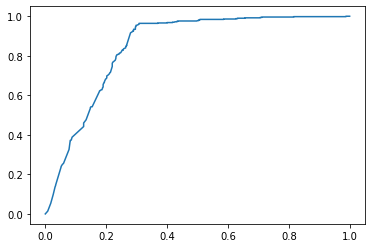

In [ ]:
attack_model.evaluate(np.concatenate((D_out[:, :-1], D_in[:, :-1])),  np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

# Extras

## Check target model's behaviour in perturbed images

In [ ]:
def study_perturbations(model, X, y, rs, ts):
  diffs = []
  y_pred = target_predict(model, X)    
  for c in range(10):
    #  given class acquire the changes in perturbed input instances given the model
    idx = y_pred[:, 0] == c
    X_c = X[idx]
    y_pred_c = y_pred[idx]
    perturbed_labels = augmented_queries(model, X_c, y_pred_c, rs, ts)
    # Now we have to count how many labels diverge from the predicted label
    diff = len(perturbed_labels.reshape(-1)) - sum(perturbed_labels.reshape(-1)) # the labels are binary where 1 == y_pred = y_perturbed, otherwise 0
    diffs.append(int(100 * diff/len(perturbed_labels.reshape(-1)))) # append the percentage of changes in the class sample
    
  return diffs 

In [ ]:
N_SAMPLES = 100
train_idx = np.random.choice(range(train_images.shape[0]), N_SAMPLES, replace=False)
test_idx = np.random.choice(range(attacker_images.shape[0]), N_SAMPLES, replace=False)

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

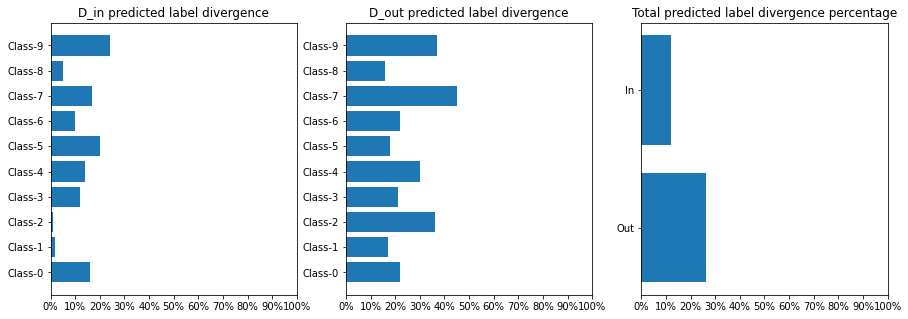

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

## Attack a perturbation trained model

- We will apply augmentations to the dataset and re-train the target model.
- The attacker **does not** know our augmentation settings, so he will train with a normal dataset of zero augmentations
- We want to measure the quality of the attack when the target tries to defend MIAs by adding perturbed images of data samples 

In [ ]:
# We will defend against the same rotations and translations that the attack models uses (worst case for the attacker)
rotates = create_rotates(r)
translates = create_translates(d)

X_train_aug = train_images
X_eval_aug = eval_images
y_train_aug = np.concatenate(tuple([train_labels] + [train_labels for rot in rotates] + [train_labels for tra in translates]))
y_eval_aug = np.concatenate(tuple([eval_labels] + [eval_labels for rot in rotates] + [eval_labels for tra in translates]))



for rot in rotates:
  aug_x = apply_augment(train_images, rot, 'r')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, rot, 'r')
  X_eval_aug = np.concatenate((X_eval_aug,aug_x))

for tra in translates:
  aug_x = apply_augment(train_images, tra, 'd')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, tra, 'd')
  X_eval_aug = np.concatenate((X_eval_aug ,aug_x))


In [ ]:

with tf.device('/gpu:0'):
  X_train_aug = tf.convert_to_tensor(X_train_aug)
  y_train_aug = tf.convert_to_tensor(y_train_aug)
  X_eval_aug = tf.convert_to_tensor(X_eval_aug)
  y_eval_aug = tf.convert_to_tensor(y_eval_aug)
  target_model = f_target(X_train_aug, y_train_aug, X_eval_aug, y_eval_aug, epochs=10) 

Epoch 1/10
1375/1375 [==============================] - 19s 13ms/step - loss: 1.4369 - accuracy: 0.4849 - val_loss: 1.7567 - val_accuracy: 0.4453
Epoch 2/10
1375/1375 [==============================] - 18s 13ms/step - loss: 0.6120 - accuracy: 0.7916 - val_loss: 2.3232 - val_accuracy: 0.4479
Epoch 3/10
1375/1375 [==============================] - 18s 13ms/step - loss: 0.3004 - accuracy: 0.9025 - val_loss: 2.7799 - val_accuracy: 0.4576
Epoch 4/10
1375/1375 [==============================] - 18s 13ms/step - loss: 0.2099 - accuracy: 0.9358 - val_loss: 2.8301 - val_accuracy: 0.4597
Epoch 5/10
1375/1375 [==============================] - 17s 12ms/step - loss: 0.1913 - accuracy: 0.9427 - val_loss: 2.9066 - val_accuracy: 0.4625
Epoch 6/10
1375/1375 [==============================] - 18s 13ms/step - loss: 0.1556 - accuracy: 0.9532 - val_loss: 3.1514 - val_accuracy: 0.4544
Epoch 7/10
1375/1375 [==============================] - 17s 12ms/step - loss: 0.1516 - accuracy: 0.9562 - val_loss: 3.7347 -

The model is quite overfitted so now all that is left is to evaluate the attack model we created before on the newly trained and "defended" target model with perturbations in the train dataset.

class-1 acc: 0.738095223903656
class-2 acc: 0.7446808218955994
class-3 acc: 0.8965517282485962
class-4 acc: 0.9019607901573181
class-5 acc: 0.8356807231903076
class-6 acc: 0.816216230392456
class-7 acc: 0.7710280418395996
class-8 acc: 0.7864583134651184
class-9 acc: 0.7464115023612976
class-10 acc: 0.7802197933197021
              precision    recall  f1-score   support

         0.0       0.95      0.64      0.76      1000
         1.0       0.73      0.97      0.83      1000

    accuracy                           0.80      2000
   macro avg       0.84      0.80      0.80      2000
weighted avg       0.84      0.80      0.80      2000

AUC: 0.8526244999999999


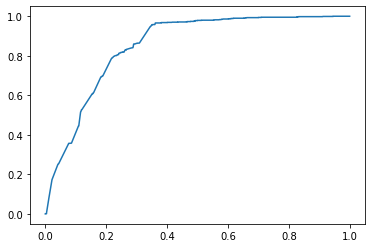

In [ ]:
D_in = attack_model.prepare_batch(target_model, train_images[:1000], train_labels[:1000], True)

D_out = attack_model.prepare_batch(target_model, attacker_images[:1000], attacker_labels[:1000], False)

attack_model.evaluate(np.concatenate((D_out[:, :-1], D_in[:, :-1])),  np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

### Conclusion

To conclude if the model is more vulnerable, we must meassure the label divergence percentage in the adjusted-to-augmentations model.

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

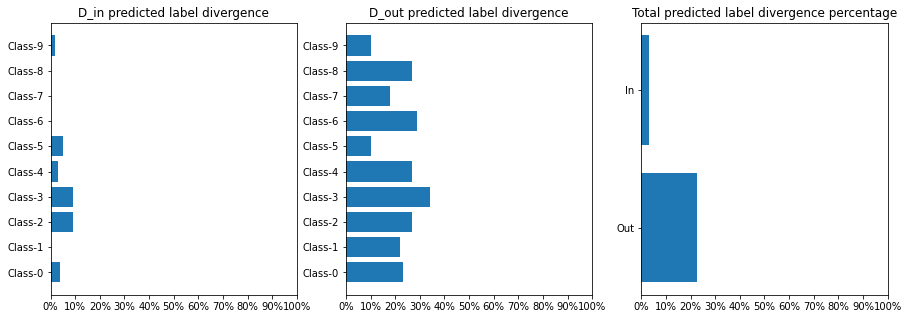

In [ ]:
# test it onthe same data as we tested the non-adjusted to augmentation model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can see that the general percentage of predicted label divergence has fallen, **but** the confidence of the ML algorithm in predicting the label of perturbed instances of instances in $D_{in}$ is better that before and that is realized by the increase of the AUC value (~0.852 when before ~0.847). This means that the adjusted model is even more vulnerable and our attack predicts membership with high sensitivity to the predicted label changes.